# Binary Classification of 747 vs A380
The goal is to classify a picture between two classes : an Boeing 747 or an Airbus A380

There is a nice script to get images from Google : https://github.com/boxabirds/fastai-helpers/blob/master/training-data-generator.py, it's based on https://github.com/hardikvasa/google-images-download wich use ChromeDriver to automate the process.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
PATH = "../../datasets/boeing_vs_airbus/"
!rm -r {PATH}/tmp
## Getting dataset
#!mkdir {PATH}
#!pip install google_images_download
#!ls ../../datasets/
#!cd {PATH} && mkdir -p train/747 train/A380 test/747 test/A380  valid/747 valid/A380
#!cd {PATH}/747 && googleimagesdownload --keywords "Boing 747" --limit 1000 --chromedriver /usr/local/bin/chromedriver
#!cd {PATH}/A380 && googleimagesdownload --keywords "Airbus A380" --limit 1000 --chromedriver /usr/local/bin/chromedriver
## Getting models weights
#!cd ./fastai && wget http://files.fast.ai/models/weights.tgz && tar -xvzf weights.tgz
#!ls {PATH}

In [3]:
print("Setting CUDA devices...")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="6"
print("Loading Fast.AI modules...")
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

sz=299
arch=resnext50
#arch=resnet34
bs=132

def plot_ep_vals(ep_vals):
    plt.ylabel("loss")
    plt.xlabel("epoch")
    epochs = len(ep_vals)#ep_vals.keys()
    #plt.xticks(np.asarray(list(epochs)))
    plt.xticks((list(ep_vals)))
    #print((list(ep_vals)))
    trn_losses = [item[0] for item in list(ep_vals.values())]
    #print(trn_losses)
    val_losses = [item[1] for item in list(ep_vals.values())]
    #print(val_losses)
    plt.plot(list(ep_vals), trn_losses, c='b', label='train')
    plt.plot(list(ep_vals), val_losses, c='r', label='validation')
    plt.legend(loc='upper left')

def plot_the_confusion_matrix():
    log_preds,y = learn.TTA()
    probs = np.mean(np.exp(log_preds),0)
    accuracy_np(probs, y)
    preds = np.argmax(probs, axis=1)
    probs = probs[:,1]
    cm = confusion_matrix(y, preds)
    plot_confusion_matrix(cm, data.classes)
    # precission = VP / (VP + FP)
    precision = cm[0][0]/(cm[0][1]+cm[0][0]);
    print("Precision : ", precision)
    # recall =  = VP / (VP + FN)
    recall = cm[0][0]/(cm[1][0]+cm[0][0]);
    print("Recall : ", recall)
    F1 = 2 * ((precision*recall)/(precision + recall))
    print("F1 : ", F1)
    F2 = 5 * ((precision*recall)/(4*precision + recall))
    print("F2 : ", F2)
    return cm

Setting CUDA devices...
Loading Fast.AI modules...


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
print("CuDNN optimization is ", torch.backends.cudnn.enabled)

CuDNN optimization is  True


# Training from sratch
We begin with an empty ResNext50 model.
First we compute the mean and standard deviation of all images to center them.
## Computing mean and stddev

In [5]:

import glob
import PIL
means = np.array([0.0,0.0,0.0])
files = [val for sublist in [[os.path.join(i[0], j) for j in i[2]] for i in os.walk(f'{PATH}train')] for val in sublist]
print("Input images number : ", len(files))
deviations = np.array([0.0,0.0,0.0])
#variances = np.array([0,0,0])
variance = np.array([0.0,0.0,0.0])
for image in files:
    #print(image)
    img_stats = PIL.ImageStat.Stat(PIL.Image.open(image), mask=None)
    means += np.array(img_stats.mean)
    variance += np.array(img_stats.var)

stddev = np.sqrt(variance) / len(files)
print("stddev with PIL : ", stddev)

mean = np.array(means) / len(files) / 255
print("Means with PIL : ", mean)
stats = (mean, stddev)

Input images number :  1310


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


stddev with PIL :  [1.54975 1.51391 1.60444]
Means with PIL :  [0.53286 0.5643  0.59667]


### Prepare data an model

In [6]:
image_size=128
#stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))
tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=4, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=False)

In [7]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 299, 299]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 75, 75]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 75, 

The model is realy deep as it make use of 168 layers.

How much input data do we get ?

(array([666.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 644.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

(array([155.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 155.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

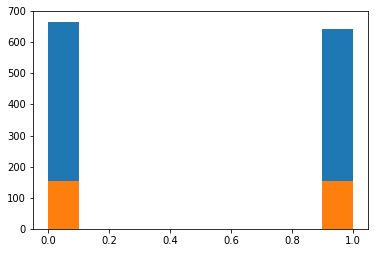

In [8]:
# This is the label for a val data
plt.hist(data.trn_y)
plt.hist(data.val_y)

/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


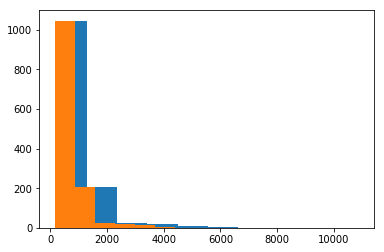

In [9]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)
plt.hist(row_sz);
plt.hist(col_sz);

(array([ 23.,  51.,  49.,  74., 119., 179.,  77., 100.,  33.,  59.]),
 array([220. , 297.2, 374.4, 451.6, 528.8, 606. , 683.2, 760.4, 837.6, 914.8, 992. ]),
 <a list of 10 Patch objects>)

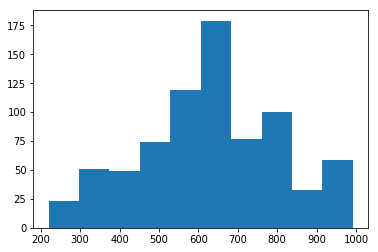

In [10]:
plt.hist(row_sz[row_sz < 1000])

We have few data

### Guess learning rate

 92%|█████████▏| 301/328 [00:15<00:01, 19.24it/s, loss=3.03] 

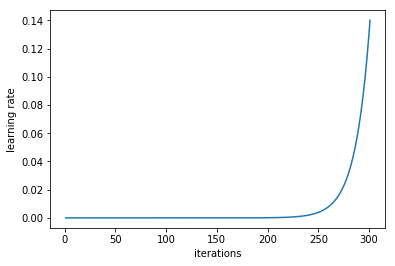

In [11]:
lrf=learn.lr_find(1e-10, end_lr=1)
learn.sched.plot_lr()

In [12]:
#?learn.lr_find

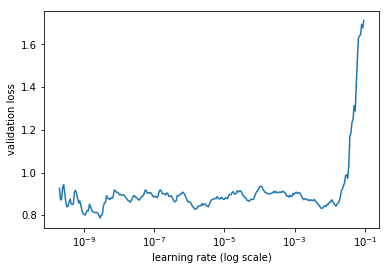

In [13]:
learn.sched.plot()

epoch      trn_loss   val_loss   accuracy                    
    0      0.797304   0.718983   0.467742  
    1      0.768672   0.70942    0.467742                    
    2      0.717871   0.711305   0.483871                    
    3      0.760268   0.720242   0.490323                    
    4      0.73147    0.706532   0.474194                    
    5      0.712881   0.700264   0.503226                    
    6      0.709045   0.697026   0.506452                    
    7      0.730822   0.697619   0.487097                    
    8      0.678626   0.697654   0.519355                    
    9      0.71902    0.696206   0.532258                    
    10     0.71465    0.694515   0.541935                    
    11     0.725181   0.694748   0.509677                    
    12     0.69505    0.694323   0.525806                    
    13     0.709533   0.695072   0.493548                    
    14     0.703891   0.693071   0.5                         
    15     0.724955   0.69

array([[155,   0],
       [155,   0]])

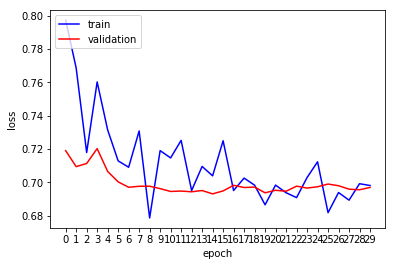

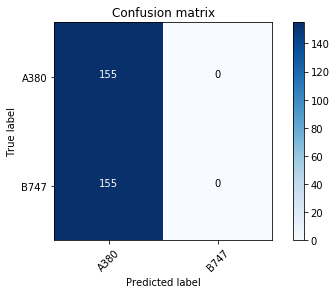

In [14]:
# F2 :  0.54 for lr=1e-4, image_size=128, batch_size=256, epoch=30
# F2 :  0.55 for lr=1e-5, image_size=128, batch_size=128, epoch=30, mais courbe erratique
# F2 :  0.49 for lr=1e-3, image_size=128, batch_size=256, epoch=30

lr=1e-4
image_size=128
batch_size=256
epoch=30
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, image_size), bs=batch_size, num_workers=num_cpus())
vals_s2s, global_results = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=False)
print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
plot_ep_vals(global_results)
plot_the_confusion_matrix()

The model had learn quite nothing. But it is not surprising with so small dataset.

## Fine tuning

epoch      trn_loss   val_loss   accuracy                  
    0      0.845482   0.933066   0.53871   
    1      0.728686   1.108146   0.590323                  
    2      0.60734    0.829937   0.719355                  
    3      0.50006    0.561374   0.796774                  
    4      0.405462   0.736781   0.745161                  
    5      0.319133   0.595116   0.803226                  
    6      0.255463   0.683389   0.816129                  
    7      0.20805    0.677776   0.812903                  
    8      0.167824   0.698573   0.812903                  
    9      0.138514   0.762232   0.8                       
    10     0.117437   0.641821   0.822581                  
    11     0.101708   0.857725   0.822581                  
    12     0.085914   0.69349    0.835484                   
    13     0.074174   0.781023   0.819355                   
    14     0.068192   0.642701   0.83871                    
    15     0.06732    0.668187   0.845161            

array([[126,  29],
       [ 25, 130]])

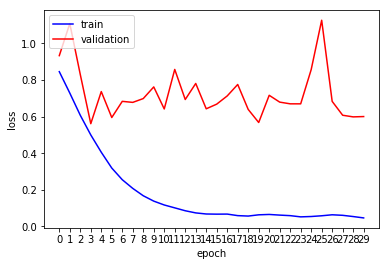

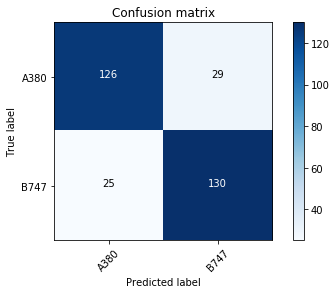

In [15]:
!rm -r {PATH}/tmp
# F2 :  0.78 for image_size=128, batch_size=150, lr=1e-3, epoch=30
# F2 :  0.83 for image_size=128, batch_size=128, lr=1e-2, epoch=30
# F2 :  0.77 for image_size=128, batch_size=150, lr=1e-4, epoch=30
# F2 :  0.80 for image_size=128, batch_size=150, lr=1e-2, epoch=30

image_size=128
batch_size=128
lr=1e-2
epoch=30
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, image_size), bs=batch_size, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=True)
learn.unfreeze()
vals_s2s, global_results = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
plot_ep_vals(global_results)
plot_the_confusion_matrix()

## Data augmentation
Data augmentation options : https://becominghuman.ai/data-augmentation-using-fastai-aefa88ca03f1

1310

'train/A380/463..jpg'

/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


epoch      trn_loss   val_loss   accuracy                  
    0      0.910959   0.672129   0.593548  
    1      0.853498   0.634057   0.66129                  
    2      0.784469   0.619083   0.658065                  
    3      0.730637   0.590577   0.674194                  
    4      0.684313   0.575774   0.696774                  
    5      0.630858   0.551939   0.716129                  
    6      0.581212   0.538702   0.706452                  
    7      0.525099   0.519168   0.751613                  
    8      0.474186   0.526984   0.751613                 
    9      0.4274     0.508939   0.787097                  
    10     0.382408   0.517709   0.770968                  
    11     0.343818   0.526178   0.774194                  
    12     0.30867    0.521274   0.793548                  
    13     0.278785   0.502392   0.796774                  
    14     0.249692   0.506311   0.796774                  
    15     0.227308   0.521087   0.803226                 

array([[137,  18],
       [ 29, 126]])

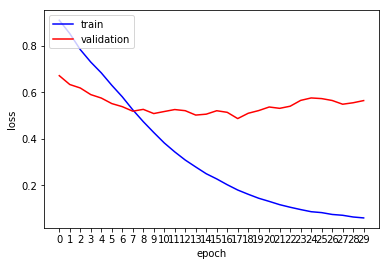

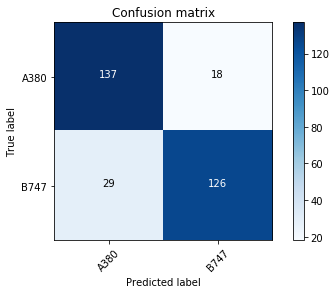

In [16]:
!rm -r {PATH}/tmp
# F2 :  0.84 for image_size=128, batch_size=150, lr=1e-3, epoch=30, ps=0.5
# F2 :  0.73 for image_size=128, batch_size=150, lr=0.0001, epoch=30, ps=0.5
# F2 :  0.79 for image_size=128, batch_size=128, lr=1e-4, epoch=30
# F2 :  0.86 for image_size=128, batch_size=128, lr=1e-3, epoch=30

image_size=128
batch_size=128
lr=1e-3
epoch=30
aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),
        RandomFlip(),
        RandomLighting(0.05, 0.05,tfm_y=TfmType.NO),
        RandomZoom(zoom_max=0.2),
        RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, image_size, aug_tfms=aug_tfms, max_zoom=1.1)

data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=batch_size, num_workers=num_cpus())

#next(iter(data.aug_dl)) Retourne batch_size images de taille sz*sz
len(data.trn_ds.fnames)
# data.trn_ds contient le dataset de test
data.trn_ds.fnames[100]

size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=True)
learn.unfreeze()
vals_s2s, global_results = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
plot_ep_vals(global_results)
plot_the_confusion_matrix()

## Multiple size

epoch      trn_loss   val_loss   accuracy                
    0      0.875417   0.705046   0.574194  
After  1  epochs, the accuracy is  57.41 %
Saving to  resnext50_1_300_acc57.41_weights


epoch      trn_loss   val_loss   accuracy                
    0      0.725011   0.639026   0.63871   
    1      0.688397   0.601594   0.667742                
    2      0.642991   0.577671   0.712903                
    3      0.590966   0.533519   0.73871                 
    4      0.540592   0.489046   0.758065                
    5      0.485605   0.492523   0.754839                
    6      0.445969   0.481991   0.767742                
    7      0.408422   0.478339   0.787097                
    8      0.365141   0.481869   0.790323                
    9      0.33006    0.48242    0.8                     
After  11  epochs, the accuracy is  80.00 %
Saving to  resnext50_11_64_acc80.00_weights


epoch      trn_loss   val_loss   accuracy                
    0      0.17383    0.482299   0.796774  
    1      0.16922    0.468755   0.806452                
    2      0.161744   0.466716   0.793548                
    3      0.149263   0.442001   0.809677                
    4      0.136296   0.442901   0.825806                
    5      0.126094   0.427244   0.822581                
    6      0.112506   0.423549   0.812903                
    7      0.106617   0.458092   0.803226                
    8      0.098405   0.45819    0.809677                 
    9      0.090848   0.461918   0.832258                 
After  21  epochs, the accuracy is  83.22 %
Saving to  resnext50_21_128_acc83.22_weights


epoch      trn_loss   val_loss   accuracy                 
    0      0.050286   0.456066   0.835484  
    1      0.052995   0.457011   0.819355                 
    2      0.054581   0.444248   0.812903                 
    3      0.049823   0.445976   0.816129                 
    4      0.046636   0.455907   0.819355                 
    5      0.046257   0.476737   0.812903                 
    6      0.045878   0.489678   0.816129                 
    7      0.042397   0.502069   0.803226                 
    8      0.038133   0.504829   0.816129                 
After  30  epochs, the accuracy is  81.61 %
Saving to  resnext50_30_300_acc81.61_weights
[[135  20]                                   
 [ 29 126]]
Precision :  0.8709677419354839
Recall :  0.823170731707317
F1 :  0.8463949843260188
F2 :  0.8323057953144266


array([[135,  20],
       [ 29, 126]])

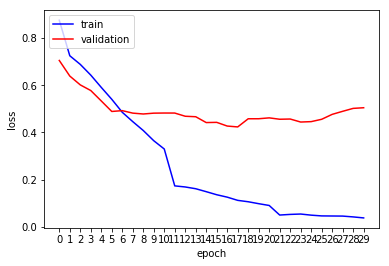

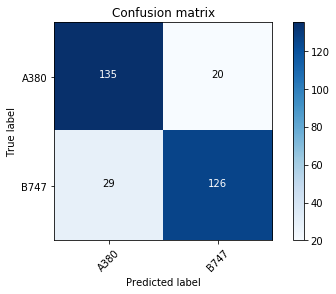

In [17]:
!rm -r {PATH}/tmp
# F2 :  0.67 for learning_rate = 1e-4, dropout = [0.25,0.5], image_size = 128, batch_size = 150
# F2 :  0.62 pour dropout =[0.25,0.5] et learning_rate = 1e-3
# F2 :  0.79 pour dropout = 0.5 et learning_rate = 1e-3
# F2 :  0.85 for learning_rate = 1e-2, dropout = 0.5, image_size = 128, batch_size = 150
# F2 :  0.86 for learning_rate = 1e-2, dropout = 0.5, image_size = 128, batch_size = 150


learning_rate = 1e-2
dropout = 0.5
image_size = 128
batch_size = 150

global_results = collections.OrderedDict([])
aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO), RandomFlip(), RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2),RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, image_size, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=batch_size, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=dropout, pretrained=True)
learn.unfreeze()
training_loop = [
    [123, 300, 1],
    [512, 64, 10],
    [150, 128, 10],
    [123, 300, 9],
]

for bs, sz, epoch in training_loop:
    lr=np.array([learning_rate/100,learning_rate/10,learning_rate]) # Learning rate plus faible pour les premières couche, pour ré-apprendre un peu si necessaire
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
    if len(global_results) > 0:
        #print(global_results)
        for k, v in ep_vals_s2s.items():
            global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)
plot_ep_vals(global_results)
plot_the_confusion_matrix()

## SGDR - Learning rate anealing

SGDR : Earlier we said 3 is the number of epochs, but it is actually *cycles*. So if cycle_len=2 , it will do 3 cycles where each cycle is 2 epochs (i.e. 6 epochs). Then why did it 7? It is because of cycle_mult :
    cycle_mult=2 : this multiplies the length of the cycle after each cycle (1 epoch + 2 epochs + 4 epochs = 7 epochs).

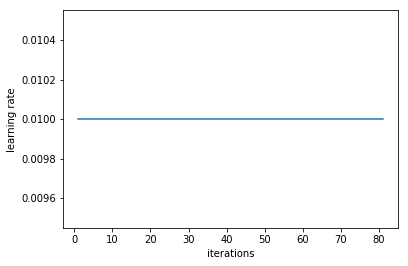

In [18]:
learn.sched.plot_lr()

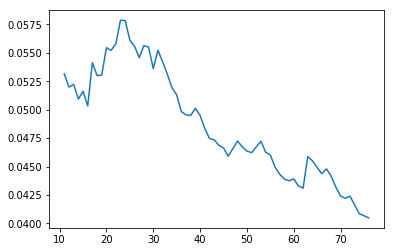

In [19]:
learn.sched.plot_loss()

Hyperparameters : Batch size= 123  Drop out= [0.25, 0.5]  Learning rate= 0.0001  Cycle= 1  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                    
    0      0.893464   0.874807   0.464516  
After  1  epochs, the accuracy is  46.45 %
Saving to  resnext50_1_300_acc46.45_weights
Hyperparameters : Batch size= 512  Drop out= [0.25, 0.5]  Learning rate= 0.0001  Cycle= 10  Images sizes= 64


epoch      trn_loss   val_loss   accuracy                    
    0      0.848065   0.86356    0.490323  
    1      0.80584    0.840918   0.545161                    
    2      0.763139   0.781049   0.545161                    
    3      0.76138    0.740733   0.596774                    
    4      0.687213   0.695028   0.616129                    
    5      0.687958   0.686778   0.616129                    
    6      0.651087   0.631936   0.651613                    
    7      0.647068   0.64715    0.632258                    
    8      0.647134   0.642036   0.632258                    
    9      0.686521   0.61862    0.648387                    
After  11  epochs, the accuracy is  64.83 %
Saving to  resnext50_11_64_acc64.83_weights
Hyperparameters : Batch size= 150  Drop out= [0.25, 0.5]  Learning rate= 0.0001  Cycle= 10  Images sizes= 128


epoch      trn_loss   val_loss   accuracy                    
    0      0.638911   0.639322   0.632258  
    1      0.604192   0.601539   0.683871                    
    2      0.58481    0.578213   0.667742                    
    3      0.542906   0.63979    0.648387                    
    4      0.586992   0.560958   0.690323                    
    5      0.566009   0.597615   0.667742                    
    6      0.548717   0.529181   0.722581                    
    7      0.520876   0.560339   0.706452                    
    8      0.564581   0.555557   0.709677                    
    9      0.514442   0.522553   0.732258                    
After  21  epochs, the accuracy is  73.22 %
Saving to  resnext50_21_128_acc73.22_weights
Hyperparameters : Batch size= 123  Drop out= [0.25, 0.5]  Learning rate= 0.0001  Cycle= 10  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                    
    0      0.47749    0.503327   0.748387  
    1      0.507816   0.496779   0.741935                    
    2      0.485288   0.489821   0.751613                    
    3      0.493982   0.508791   0.735484                    
    4      0.49262    0.505355   0.73871                     
    5      0.503935   0.554294   0.725806                    
    6      0.484743   0.555904   0.716129                    
    7      0.443776   0.543186   0.712903                    
    8      0.439241   0.497443   0.735484                    
    9      0.434778   0.503471   0.745161                    
After  31  epochs, the accuracy is  74.51 %
Saving to  resnext50_31_300_acc74.51_weights


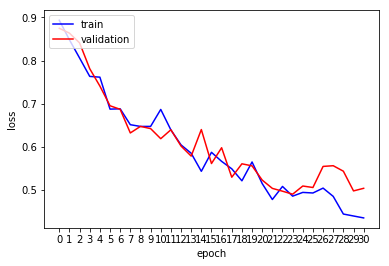

In [20]:
!rm -r {PATH}/tmp
# F2 :  0.80 pour [0.25,0.5] et 1e-4
# F2 :  0.76 pour dropout = 0.5 et learning_rate = 1e-4
# F2 :  0.76  for learning_rate = 1e-3, dropout = [0.25,0.5], lr=np.array([learning_rate/100,learning_rate/10,learning_rate]
# F2 :  0.49 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5] 
# F2 :  0.74 for learning_rate = 1e-4, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5] 
# F2 :  0.53 for learning_rate = 1e-4, lr=np.array([learning_rate/5,learning_rate/3,learning_rate]), dropout = [0.25,0.5]


learning_rate = 1e-4
lr=np.array([learning_rate/100,learning_rate/10,learning_rate])
dropout = [0.25,0.5] 


aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),RandomFlip(),RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2), RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
learn.unfreeze()
learn.ps=dropout
global_results = collections.OrderedDict([])

training_loop = [
    [123, 300, 1],
    [512, 64, 10],
    [150, 128, 10],
    [123, 300, 10],
]
#    [256, 128, 3],
#    [123, 300, 3],
#    [64, 600, 3],
#    [123, 300, 4],
#    [256, 128, 2],
#    [123, 300, 2],
#    [64, 600, 3],
#    [123, 400, 2]
for bs, sz, epoch in training_loop:
    print("Hyperparameters : Batch size=", bs, " Drop out=", dropout, " Learning rate=", learning_rate, " Cycle=", epoch, " Images sizes=", sz )
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    # On recharge les données avec une taille de batch plus importante pour aller plus vite
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, n_cycle=epoch, cycle_len=1, get_ep_vals=True)
    if len(global_results) > 0:
        for k, v in ep_vals_s2s.items(): global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)
plot_ep_vals(global_results)


[[137  18]                                   
 [ 34 121]]
Precision :  0.8838709677419355
Recall :  0.8011695906432749
F1 :  0.8404907975460123
F2 :  0.8164481525625745


array([[137,  18],
       [ 34, 121]])

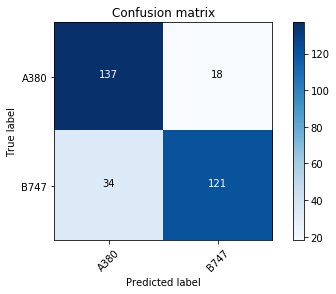

In [21]:
plot_the_confusion_matrix()

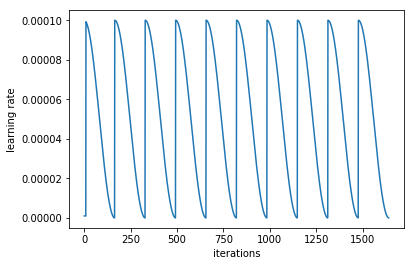

In [22]:
learn.sched.plot_lr()

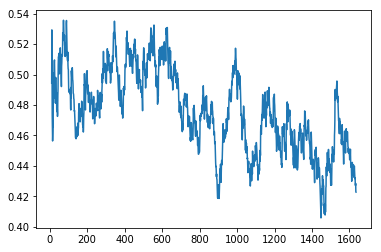

In [23]:
learn.sched.plot_loss()

## Variable cycle length

In [24]:
!rm -r {PATH}/tmp
learning_rate = 1e-3
lr=np.array([learning_rate/10,learning_rate/5,learning_rate])
dropout = 0.5 # [0.25,0.5]
# F2 :  0.66 pour learning_rate = 1e-3 et dropout = [0.25,0.5]
# F2 :  0.85 for learning_rate = 1e-3, dropout = [0.25,0.5]
# F2 :  0.86 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = 0.5

aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),RandomFlip(),RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2), RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
learn.unfreeze()
learn.ps=dropout
global_results = collections.OrderedDict([])

training_loop = [
    [123, 300, 3],
    [512, 64, 4],
    [256, 128, 3],
    [123, 400, 4]
]
for bs, sz, cycle in training_loop:
    print("Hyperparameters : Batch size=", bs, " Drop out=", dropout, " Learning rate=", learning_rate, " Cycle=", cycle, " Images sizes=", sz )
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, cycle, cycle_len=1, cycle_mult=2, get_ep_vals=True)
    if len(global_results) > 0:
        for k, v in ep_vals_s2s.items(): global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)


Hyperparameters : Batch size= 123  Drop out= 0.5  Learning rate= 0.001  Cycle= 3  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                    
    0      0.678156   0.580503   0.683871  
    1      0.569391   0.526373   0.729032                    
    2      0.488171   0.437746   0.767742                    
    3      0.410683   0.462252   0.748387                    
    4      0.313819   0.313853   0.867742                    
    5      0.32446    0.280425   0.877419                    
    6      0.276847   0.275132   0.867742                    
After  7  epochs, the accuracy is  86.77 %
Saving to  resnext50_7_300_acc86.77_weights
Hyperparameters : Batch size= 512  Drop out= 0.5  Learning rate= 0.001  Cycle= 4  Images sizes= 64


epoch      trn_loss   val_loss   accuracy                    
    0      0.240277   0.294517   0.864516  
    1      0.246209   0.250542   0.896774                    
    2      0.200172   0.240106   0.909677                    
    3      0.227065   0.280172   0.883871                    
    4      0.230373   0.227352   0.9                         
    5      0.158456   0.273057   0.877419                    
    6      0.110899   0.214477   0.887097                    
    7      0.148994   0.241879   0.893548                    
    8      0.147199   0.311927   0.867742                    
    9      0.151548   0.218293   0.896774                    
    10     0.128796   0.215623   0.906452                    
    11     0.145112   0.183923   0.945161                    
    12     0.10469    0.185592   0.93871                     
    13     0.179562   0.183067   0.929032                    
    14     0.118268   0.187801   0.925806                    
After  22  epochs, the acc

epoch      trn_loss   val_loss   accuracy                     
    0      0.123992   0.172048   0.93871   
    1      0.084702   0.173663   0.954839                     
    2      0.10113    0.202742   0.903226                     
    3      0.115639   0.21901    0.912903                    
    4      0.140502   0.2249     0.906452                    
    5      0.093584   0.18647    0.935484                     
    6      0.130446   0.187081   0.932258                     
After  29  epochs, the accuracy is  93.22 %
Saving to  resnext50_29_128_acc93.22_weights
Hyperparameters : Batch size= 123  Drop out= 0.5  Learning rate= 0.001  Cycle= 4  Images sizes= 400


epoch      trn_loss   val_loss   accuracy                    
    0      0.104533   0.205452   0.906452  
    1      0.092493   0.17846    0.932258                     
    2      0.107053   0.179153   0.925806                     
    3      0.209725   0.14336    0.941935                     
    4      0.095528   0.184767   0.906452                     
    5      0.077972   0.152095   0.948387                     
    6      0.085789   0.15621    0.935484                     
    7      0.133071   0.161553   0.941935                     
    8      0.070415   0.182268   0.925806                     
    9      0.122188   0.163952   0.945161                     
    10     0.066472   0.215517   0.903226                     
    11     0.087015   0.176583   0.941935                     
    12     0.137714   0.187376   0.916129                     
    13     0.152164   0.158529   0.935484                     
    14     0.109733   0.16512    0.945161                     
After  44  e

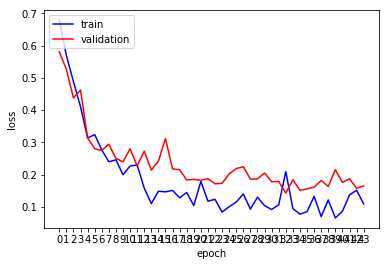

In [25]:
#plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plot_ep_vals(global_results)


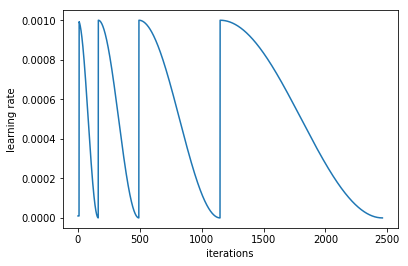

In [26]:
learn.sched.plot_lr()

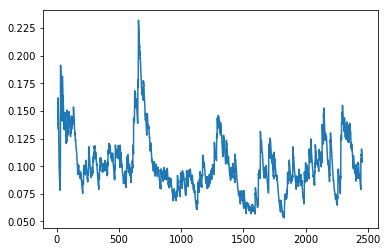

In [27]:
learn.sched.plot_loss()

[[148   7]                                   
 [  4 151]]
Precision :  0.9548387096774194
Recall :  0.9736842105263158
F1 :  0.964169381107492
F2 :  0.9698558322411533


array([[148,   7],
       [  4, 151]])

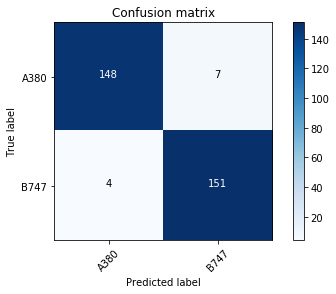

In [28]:
plot_the_confusion_matrix()

# More epochs

In [29]:
!rm -r {PATH}/tmp
# resnext50 results :
    # F2 :  0.84 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]
    # F2 :  0.69 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]


learning_rate = 1e-3
lr=np.array([learning_rate/10,learning_rate/5,learning_rate])
dropout = [0.25,0.5]
arch=resnet34
aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),RandomFlip(),RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2), RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, 299, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
learn.unfreeze()
learn.ps=dropout
global_results = collections.OrderedDict([])

training_loop = [
    [512, 64, 4],
    [256, 128, 3],
    [123, 300, 3],
    [64, 600, 3]

#     [123, 300, 3],
#     [512, 64, 4],
#     [256, 128, 3],
#     [64, 600, 3]
    
#     [123, 300, 6],
#     [256, 128, 2],
#     [123, 300, 2],
#     [64, 600, 3]
#     [123, 400, 6]
]
for bs, sz, cycle in training_loop:
    print("Hyperparameters for ", arch.__name__, " : Batch size=", bs, " Drop out=", dropout, " Learning rate=", learning_rate, " Cycle=", cycle, " Images sizes=", sz )
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, cycle, cycle_len=1, cycle_mult=2, get_ep_vals=True)
    if len(global_results) > 0:
        for k, v in ep_vals_s2s.items(): global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)



Hyperparameters for  resnet34  : Batch size= 512  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 4  Images sizes= 64


epoch      trn_loss   val_loss   accuracy                    
    0      0.735948   0.644218   0.648387  
    1      0.659132   0.538372   0.751613                    
    2      0.576624   0.532552   0.741935                    
    3      0.520561   0.45734    0.793548                    
    4      0.44504    0.398806   0.806452                    
    5      0.411396   0.398795   0.803226                    
    6      0.381175   0.387751   0.8                         
    7      0.395407   0.337945   0.848387                    
    8      0.383345   0.372158   0.83871                     
    9      0.358618   0.308341   0.864516                    
    10     0.292912   0.292526   0.86129                     
    11     0.246973   0.28014    0.870968                    
    12     0.227567   0.269865   0.874194                    
    13     0.256092   0.25763    0.887097                    
    14     0.224464   0.265083   0.880645                    
After  15  epochs, the acc

epoch      trn_loss   val_loss   accuracy                    
    0      0.249954   0.27893    0.893548  
    1      0.204359   0.257704   0.867742                    
    2      0.195778   0.244121   0.867742                    
    3      0.23583    0.226058   0.896774                    
    4      0.206665   0.259972   0.893548                    
    5      0.214883   0.233176   0.890323                    
    6      0.180961   0.263663   0.887097                    
After  22  epochs, the accuracy is  88.70 %
Saving to  resnet34_22_128_acc88.70_weights
Hyperparameters for  resnet34  : Batch size= 123  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 3  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                    
    0      0.165371   0.235184   0.906452  
    1      0.169907   0.217297   0.903226                    
    2      0.183736   0.267451   0.887097                    
    3      0.131908   0.227987   0.903226                    
    4      0.169569   0.229948   0.903226                    
    5      0.144292   0.216918   0.906452                    
    6      0.141318   0.203942   0.912903                    
After  29  epochs, the accuracy is  91.29 %
Saving to  resnet34_29_300_acc91.29_weights
Hyperparameters for  resnet34  : Batch size= 64  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 3  Images sizes= 600


epoch      trn_loss   val_loss   accuracy                    
    0      0.188123   0.208994   0.912903  
    1      0.156869   0.185163   0.922581                    
    2      0.137158   0.237771   0.909677                    
    3      0.190677   0.186648   0.916129                    
    4      0.114893   0.164455   0.925806                    
    5      0.13394    0.188906   0.916129                    
    6      0.142006   0.196573   0.9                         
After  36  epochs, the accuracy is  90.0 %
Saving to  resnet34_36_600_acc90.0_weights


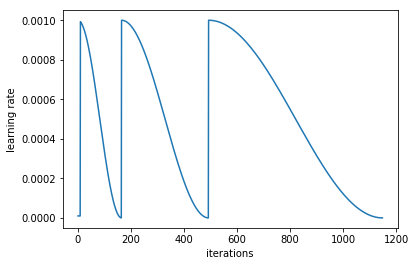

In [30]:
learn.sched.plot_lr()

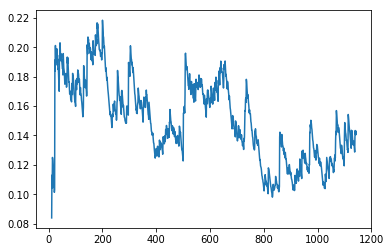

In [31]:
learn.sched.plot_loss()

<Figure size 1120x640 with 0 Axes>

[[148   7]                                   
 [ 21 134]]
Precision :  0.9548387096774194
Recall :  0.8757396449704142
F1 :  0.9135802469135803
F2 :  0.8904933814681109


array([[148,   7],
       [ 21, 134]])

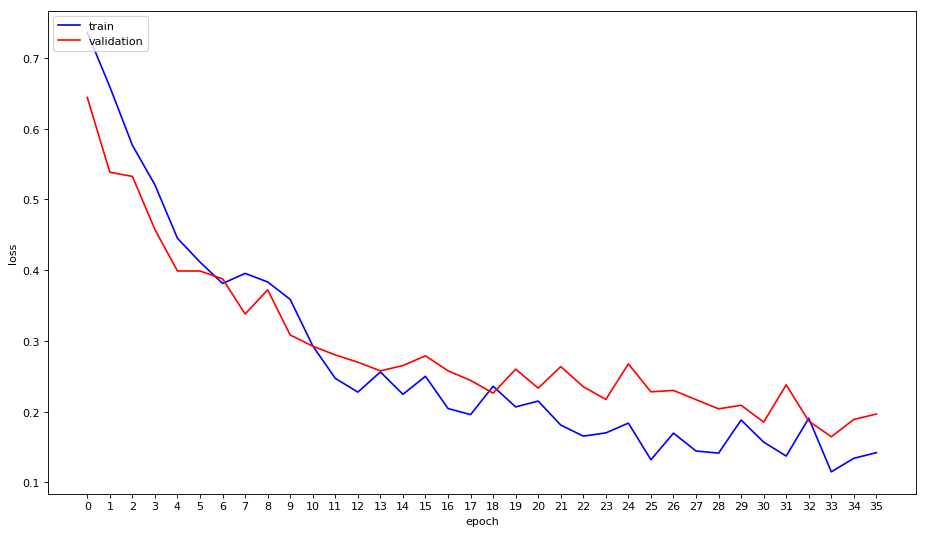

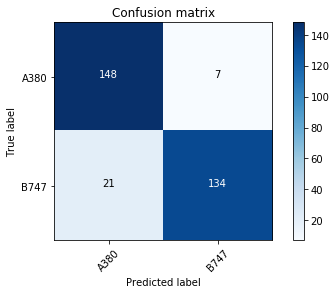

In [32]:

plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plot_ep_vals(global_results)
plot_the_confusion_matrix()

In [33]:
loadmodel=False
#loadmodel=True
if loadmodel==True:
    data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, 64), bs=123, num_workers=num_cpus())
    data = get_data(64, 64) 
    learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=False)
    learn.load("resnext50_32_400_acc95.01_weights")
    learn.freeze()
    vals_s2s, global_results = learn.fit(0.00001, n_cycle=1, get_ep_vals=True)
    plot_ep_vals(global_results)
    print("Model chargé")

# Prediction et visualisation

[[150   5]                                   
 [ 21 134]]
Precision :  0.967741935483871
Recall :  0.8771929824561403
F1 :  0.9202453987730062
F2 :  0.8939213349225268


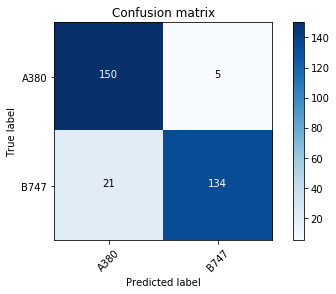

In [34]:
cm = plot_the_confusion_matrix()

In [35]:
?plot_confusion_matrix

## Precision and Recall
Précision et rappel en français : https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel
_La précision est le nombre de documents pertinents retrouvés rapporté au nombre de documents total proposé par le moteur de recherche pour une requête donnée. _ Autrement dit quelle proportion d'identifications positives était effectivement correcte ?

_Le rappel est défini par le nombre de documents pertinents retrouvés au regard du nombre de documents pertinents que possède la base de données._ Autrement dit quelle proportion de résultats positifs réels a été identifiée correctement ?

In [36]:
# precission = VP / (VP + FP)
precision = cm[0][0]/(cm[0][1]+cm[0][0]);
print("Precision : ", precision)
# recall =  = VP / (VP + FN)
recall = cm[0][0]/(cm[1][0]+cm[0][0]);
print("recall : ", recall)
F1 = 2 * ((precision*recall)/(precision + recall))
print("F1 : ", F1)
F2 = 5 * ((precision*recall)/(4*precision + recall))
print("F2 : ", F2)

Precision :  0.967741935483871
recall :  0.8771929824561403
F1 :  0.9202453987730062
F2 :  0.8939213349225268


In [37]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape  # = (nombre de prediction , nombre de classe)
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

from math import ceil
nb_images = 10

# Récupère aléatoirement des prédictions
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), nb_images), replace=False)

# Récupère les prédictions correctes
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

# Affiche les images
def plots(ims, figsize=(20,10), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i])

# Charge l'image
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

# Affiche des images avec un titre
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [(str(probs[x]) + "\n" + str(data.val_ds.fnames[x][10:][:20])) for x in idxs]
    print(title)
    nb_lignes = ceil(len(idxs) / 3)
    return plots(imgs, rows=nb_lignes, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

# Recupère les prédiction triées
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:nb_images]] # Les nb_images premiers éléments

# Recupère les prédictions les plus justes
def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

['A380', 'B747']

(310, 2)

Most incorrect A380


ValueError: num must be 1 <= num <= 6, not 7

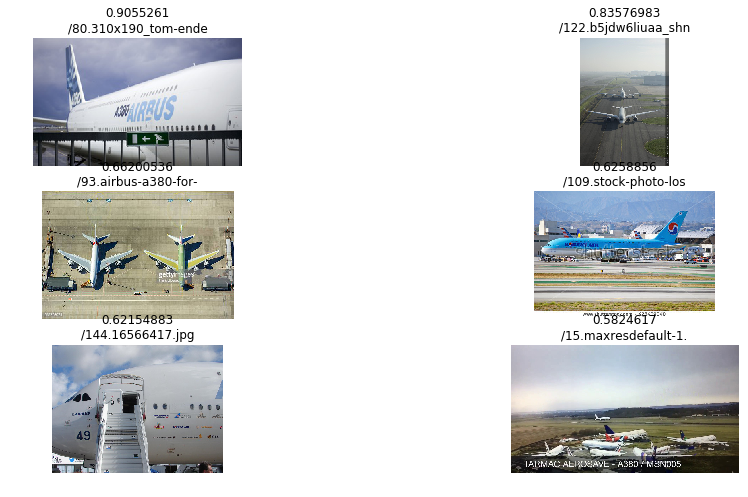

In [38]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect " + data.classes[0])

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect " + data.classes[1])

In [ ]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:nb_images]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [ ]:
plot_val_with_title(most_by_correct(1, True), "Most correct " + data.classes[1])

In [ ]:
plot_val_with_title(most_by_correct(0, True), "Most correct " + data.classes[0])
# 1. A few correct labels at random
#plot_val_with_title(rand_by_correct(True), "Correctly classified")
# 2. A few incorrect labels at random
#plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [ ]:
aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),
        RandomFlip(),
        RandomLighting(0.05, 0.05,tfm_y=TfmType.NO),
        RandomZoom(zoom_max=0.2),
        RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.1)
# Taille de batch faible pour trouver le bon learning rate
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
def get_augs():
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=2, num_workers=2)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

ims = np.stack([get_augs() for i in range(8)])
plots(ims, rows=2)

#next(iter(data.aug_dl)) Retourne batch_size images de taille sz*sz
len(data.trn_ds.fnames)
# data.trn_ds contient le dataset de test
data.trn_ds.fnames[100]

size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

In [ ]:
plt.hist(data.trn_y)

In [ ]:
plt.hist(row_sz);
plt.hist(col_sz);
plt.hist(row_sz[row_sz < 1000])

In [ ]:
#?confusion_matrix

C'est bon, les plus petites font plus de 200 pixels.
On note que la majorité on une taille importante, il sera bon de faire des entrainement du modèle avec des tailles supérieures.

_"How many images should we use as a validation set? [01:26:28] Using 20% is fine unless the dataset is small — then 20% is not enough. If you train the same model multiple times and you are getting very different validation set results, then your validation set is too small. If the validation set is smaller than a thousand, it is hard to interpret how well you are doing. If you care about the third decimal place of accuracy and you only have a thousand things in your validation set, a single image changes the accuracy. If you care about the difference between 0.01 and 0.02, you want that to represent 10 or 20 rows. Normally 20% seems to work fine."_
=> Nous avons environs 100 images de validation par classes, ça devrait donc aller.

Faisons un test d'entrainement avec une petite taille de batch pour estimer la valeur du learning rate.